# CAP-394

Course Project - Exploring Data Using Geopandas & São Paulo Region

Last update: 2019-12-30

## Objective

The objective is try to answer some questions:
- What is the month with the most accidents?
- What is the week day with the most accidents?
- What is the age group with the most accidents?
- What are the most dangerous drivers ranked by age and sex?
- How many people are killed on our roads each year?
- What are casualties by road user type?
- Do more deaths occur on country roads than on motorways?
- What are crashiest roads at night?
- What are crashiest roads for motorcycle?
- What are crashiest roads? (crash per meter)

Note: some questions are based on http://www.racfoundation.org/motoring-faqs/safety

## Data source

### Road geodata  (extracts of OpenStreetMap data)
- http://www.nextzen.org/metro-extracts/index.html
- http://s3.amazonaws.com/metro-extracts.nextzen.org/sao-paulo_brazil.imposm-geojson.zip

### BR crash data
"INFOSIGA - One of the main initiatives of the São Paulo Traffic Safety Movement is the development of a database with information on deaths due to traffic accidents in the state of São Paulo. Information is updated monthly, on the 19th or next business day, for all 645 municipalities. The database has data on the number of fatalities and the profile of accidents and victims."
- http://www.infosiga.sp.gov.br/Home/InfoMapaRelatorio
- http://www.infosiga.sp.gov.br/Home/BuscarInfoMapaRelatorioPorId/58

In [1]:
%ls data

BaseCompletaNov17.csv                sao-paulo_brazil_roads.geojson
sao-paulo_brazil_roads_gen1.geojson


## Library

In [2]:
import pandas as pd              # pandas.pydata.org
import geopandas as gpd          # geopandas.org
import matplotlib.pyplot as plt  # matplotlib.org
import numpy as np               # numpy.org
import json                      # docs.python.org/3/library/json.html
from pathlib import Path         # docs.python.org/3/library/pathlib.html
import time                      # docs.python.org/3/library/time.html

# pypi.org/project/Shapely
# Manipulation and analysis of geometric objects in the Cartesian plane
#    conda install -c conda-forge shapely
import shapely.geometry as sg

# python-visualization.github.io/folium
# Make beautiful maps with Leaflet.js (does not work on github)
#    conda install -c conda-forge folium 
import folium

# github.com/jsvine/spectra
# Color scales and color conversion made easy
#    conda install -c conda-forge spectra
import spectra

# docs.python.org/3/library/multiprocessing.html
# Allows fully leverage multiple processors on a given machine
import multiprocessing as mp

# pypi.org/project/pathos
# Configure and launch parallel computations across heterogenous resources
#    conda install -c conda-forge pathos
from pathos.multiprocessing import ProcessingPool as Pool

In [3]:
# Set the environment
DirData     = Path('data')
DirOut      = Path('out')
RoadGeod    = Path('sao-paulo_brazil_roads_gen1.geojson')
RoadGeod2   = Path('sao-paulo_brazil_roads.geojson')
CrashData   = Path('BaseCompletaNov17.csv')
ReduData    = Path('BaseRedu.csv')
CrashyRoads = Path('crashy_roads.geojson')
Temp        = Path('temp.csv')

# Magic function that renders the figure in a notebook
%matplotlib inline

# World Geodetic System coordinate system.
WGS84 = {'init': 'epsg:4326'}

# Web Mercator (WGS84/Pseudo-Mercator) coordinate system.
# Used by major online map providers, including Google Maps,
#   Mapbox, Bing Maps, OpenStreetMap, Mapquest, Esri, and others.
# <https://en.wikipedia.org/wiki/Web_Mercator_projection>
WM = {'init': 'epsg:3857'}

## Explore data

In [4]:
# Load roads as GeoDataFrame
path = DirData/RoadGeod    # 50 m tolerance (? need check)
roads = gpd.read_file(str(path))

# Clean column osm_id
roads['osm_id'] = ( roads['osm_id']
                      .astype(int)    # cut fractional part
                      .astype(str)    # convert to string
                  )

# Display
roads.head().T

,0,1,2,3,4
osm_id,4273889,4300267,4300280,4312745,4312746
type,trunk,motorway,motorway,motorway,motorway
name,Avenida Nações Unidas,Rodovia Anhanguera,Rodovia Anhanguera,Rodovia dos Bandeirantes,Rodovia dos Bandeirantes
tunnel,0,0,0,0,0
bridge,0,0,0,0,0
oneway,1,1,1,1,1
ref,None,SP-330;BR-050,SP-330;BR-050,SP-348,SP-348
z_order,8,9,9,9,9
access,None,None,None,None,None
service,None,None,None,None,None


OpenStreetMap tags

http://wiki.openstreetmap.org/wiki/Map_Features

- motorways = Freeway, Autobahn, etc..
- trunk = Important roads that are not motorways
- primary, secondary, ... = The next most important roads

In [5]:
# Convert
print('Is the current CRS WGS84?', roads.crs == WGS84)
roads = roads.to_crs(WM)
print('Is the new CRS WM?', roads.crs == WM)

# Display
roads.head().T

Is the current CRS WGS84? True
Is the new CRS WM? True


,0,1,2,3,4
osm_id,4273889,4300267,4300280,4312745,4312746
type,trunk,motorway,motorway,motorway,motorway
name,Avenida Nações Unidas,Rodovia Anhanguera,Rodovia Anhanguera,Rodovia dos Bandeirantes,Rodovia dos Bandeirantes
tunnel,0,0,0,0,0
bridge,0,0,0,0,0
oneway,1,1,1,1,1
ref,None,SP-330;BR-050,SP-330;BR-050,SP-348,SP-348
z_order,8,9,9,9,9
access,None,None,None,None,None
service,None,None,None,None,None


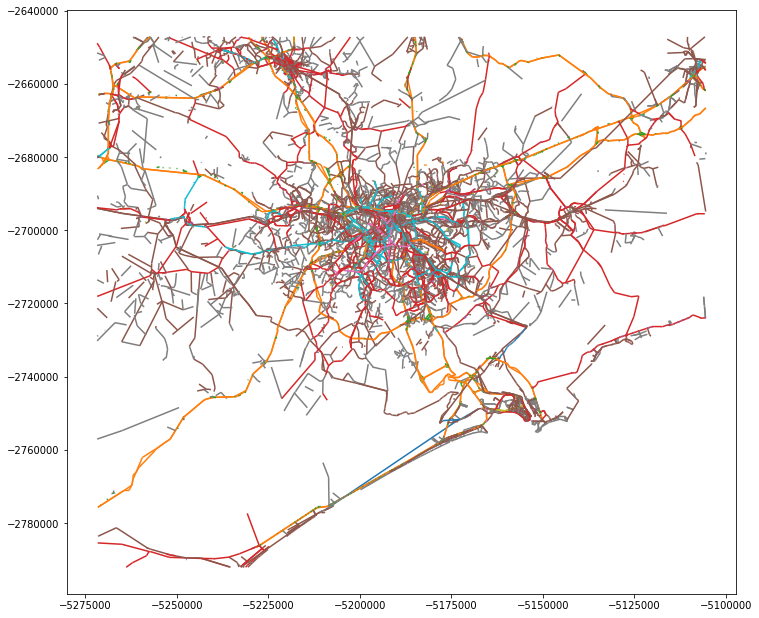

In [6]:
# Plot
f, ax = plt.subplots(1, figsize=(12, 12))
ax = roads.plot(column='type', ax=ax)

# Display
plt.show()

## Prepare crash data

In [7]:
# Filter crash data and save to (smaller) file
path = DirData/CrashData
f = pd.read_csv(path,
                sep=';',
                decimal=',',
                encoding='ISO-8859-15',
                low_memory=False,
                error_bad_lines=False
               )

# Rename columns
f = f.rename(columns={
    'Cidade Considerada':'CIDADE',
    'Região Administrativa':'REG_ADM',
    'Ano Óbito':'ANO',
    'Mês Óbito':'MES',
    'Mês Descrição':'DESC_MES',
    'Sexo':'SEXO',
    'Turno':'TURNO',
    'Tipo Acidente':'TIPO',
    'Tipo Veiculo': 'VEIC',
    'Faixa Etária':'FAIX_ETAR',
    'Idade':'IDADE',
    'Hora Acidente':'HORA',
    'Tipo Vítima':'VITIMA',
    'Tipo Local do Acidente':'LOCAL',
    'Dia Semana':'DIA_SEM',
    'Tipo de Via':"VIA",
    'LAT_(geo)':'LAT',
    'LONG_(geo)':'LONG',
    'Rua / Rodovia':'NOME',
    })

# Reformat column - str to float
f['LAT'] = ( f['LAT'].str.replace(',','.')
                     .apply(pd.to_numeric, errors='coerce')
           )
f['LONG'] = ( f['LONG'].str.replace(',','.')
                       .apply(pd.to_numeric, errors='coerce')
            )

# Delete NaN lines
f = f[ ~np.isnan(f['LAT']) ].copy()

# Display
f.head()

,CIDADE,REG_ADM,ANO,MES,DESC_MES,SEXO,TURNO,TIPO,VEIC,FAIX_ETAR,IDADE,HORA,VITIMA,LOCAL,DIA_SEM,VIA,LAT,LONG,NOME
0,SAO PAULO,Metropolitana de São Paulo,2017,10,OUTUBRO,MASCULINO,TARDE,ATROPELAMENTO,PEDESTRE,65-69,66,NaN,PEDESTRE,PUBLICO,QUARTA,Vias Municipais,-23.466729,-46.583952,AVENIDA GUAPIRA
9421,HORTOLANDIA,Campinas,2016,8,AGOSTO,MASCULINO,TARDE,NAO DISPONIVEL,NAO DISPONIVEL,18-24,24,NaN,NAO DISPONIVEL,NAO DISPONIVEL,SEGUNDA,Rodovias,-22.904026,-47.205117,SP 101
9422,POMPEIA,Marília,2016,8,AGOSTO,FEMININO,NOITE,COLISAO,AUTOMOVEL,18-24,21,NaN,PASSAGEIRO,PUBLICO,SEGUNDA,Rodovias,-22.103232,-50.216331,SP 294
9423,BRAGANCA PAULISTA,Campinas,2016,8,AGOSTO,MASCULINO,NOITE,COLISAO,AUTOMOVEL,40-44,43,NaN,NAO DISPONIVEL,PUBLICO,TERÇA,Rodovias,-22.944480,-46.476241,BR 381
9424,MOGI GUACU,Campinas,2016,8,AGOSTO,MASCULINO,NOITE,ATROPELAMENTO,PEDESTRE,18-24,19,NaN,PEDESTRE,PUBLICO,DOMINGO,Rodovias,-22.146250,-46.995781,SP 340


In [8]:
# Filter crashes and drop bad locations
#   cond = f['LG_REGION_DESC'].str.contains('Auckland')
#   cond &= (f['EASTING'] > 0) & (f['NORTHING'] > 0)
#   cond &= f['MULTI_VEH'].str.contains(r'cyclist|pedestrian',
#                                       case=False)

# drop the outside map region
cond  = (f['LAT'] < -23.1)
cond &= (f['LONG'] > -47.4)
cond &= (f['LONG'] < -45.7)

# if desired is possible to filter even more
# drop: PEDESTRE|NAO DISPONIVEL|BICICLETA|ATROPELAMENTO|OUTROS
# cond &= f['VEIC'].str.contains(
#    r'AUTO|CAMI|MOTO|ONIB'
#    )

# Filter
f2 = f[ cond ].copy()

# Display
f2.head()

,CIDADE,REG_ADM,ANO,MES,DESC_MES,SEXO,TURNO,TIPO,VEIC,FAIX_ETAR,IDADE,HORA,VITIMA,LOCAL,DIA_SEM,VIA,LAT,LONG,NOME
0,SAO PAULO,Metropolitana de São Paulo,2017,10,OUTUBRO,MASCULINO,TARDE,ATROPELAMENTO,PEDESTRE,65-69,66,NaN,PEDESTRE,PUBLICO,QUARTA,Vias Municipais,-23.466729,-46.583952,AVENIDA GUAPIRA
9426,SAO PAULO,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,MANHA,OUTROS,MOTOCICLETA,45-49,47,NaN,CONDUTOR,PUBLICO,QUINTA,Vias Municipais,-23.459970,-46.585517,Avenida Paulo Lincoln do Vale Pontim
9427,SAO PAULO,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,NOITE,ATROPELAMENTO,PEDESTRE,70-74,73,NaN,PEDESTRE,PUBLICO,SÁBADO,Vias Municipais,-23.462306,-46.582995,RUA ANTONIO CESAR NETO
9428,SAO PAULO,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,MADRUGADA,CHOQUE,MOTOCICLETA,25-29,25,NaN,NAO DISPONIVEL,PUBLICO,SEGUNDA,Vias Municipais,-23.528267,-46.587991,AVENIDA MORVAN DIAS DE FIGUEREDO
9429,FERRAZ DE VASCONCELOS,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,NOITE,CHOQUE,AUTOMOVEL,18-24,20,NaN,CONDUTOR,PUBLICO,TERÇA,Vias Municipais,-23.547639,-46.387550,RUA IJIMA


In [9]:
# Convert to GeoDataFrame

# prepare to create column geometry
geom = [sg.Point(p) for p in zip(
    f2['LONG'],    # X = easting = long
    f2['LAT']      # Y = northing = lat
    )]

# join the column
crashes = gpd.GeoDataFrame(f2, crs=WGS84, geometry=geom)

# Convert to WM
print('Is the current CRS WGS84?', crashes.crs == WGS84)
crashes = crashes.to_crs(WM)
print('Is the new CRS WM?', crashes.crs == WM)

# Save
path = DirOut/ReduData
crashes.to_csv(path, index=False)

# Display
crashes.head()

Is the current CRS WGS84? True
Is the new CRS WM? True


,CIDADE,REG_ADM,ANO,MES,DESC_MES,SEXO,TURNO,TIPO,VEIC,FAIX_ETAR,IDADE,HORA,VITIMA,LOCAL,DIA_SEM,VIA,LAT,LONG,NOME,geometry
0,SAO PAULO,Metropolitana de São Paulo,2017,10,OUTUBRO,MASCULINO,TARDE,ATROPELAMENTO,PEDESTRE,65-69,66,NaN,PEDESTRE,PUBLICO,QUARTA,Vias Municipais,-23.466729,-46.583952,AVENIDA GUAPIRA,POINT (-5185701.816 -2688560.050)
9426,SAO PAULO,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,MANHA,OUTROS,MOTOCICLETA,45-49,47,NaN,CONDUTOR,PUBLICO,QUINTA,Vias Municipais,-23.459970,-46.585517,Avenida Paulo Lincoln do Vale Pontim,POINT (-5185876.031 -2687739.821)
9427,SAO PAULO,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,NOITE,ATROPELAMENTO,PEDESTRE,70-74,73,NaN,PEDESTRE,PUBLICO,SÁBADO,Vias Municipais,-23.462306,-46.582995,RUA ANTONIO CESAR NETO,POINT (-5185595.283 -2688023.299)
9428,SAO PAULO,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,MADRUGADA,CHOQUE,MOTOCICLETA,25-29,25,NaN,NAO DISPONIVEL,PUBLICO,SEGUNDA,Vias Municipais,-23.528267,-46.587991,AVENIDA MORVAN DIAS DE FIGUEREDO,POINT (-5186151.435 -2696029.844)
9429,FERRAZ DE VASCONCELOS,Metropolitana de São Paulo,2016,8,AGOSTO,MASCULINO,NOITE,CHOQUE,AUTOMOVEL,18-24,20,NaN,CONDUTOR,PUBLICO,TERÇA,Vias Municipais,-23.547639,-46.387550,RUA IJIMA,POINT (-5163838.445 -2698382.098)


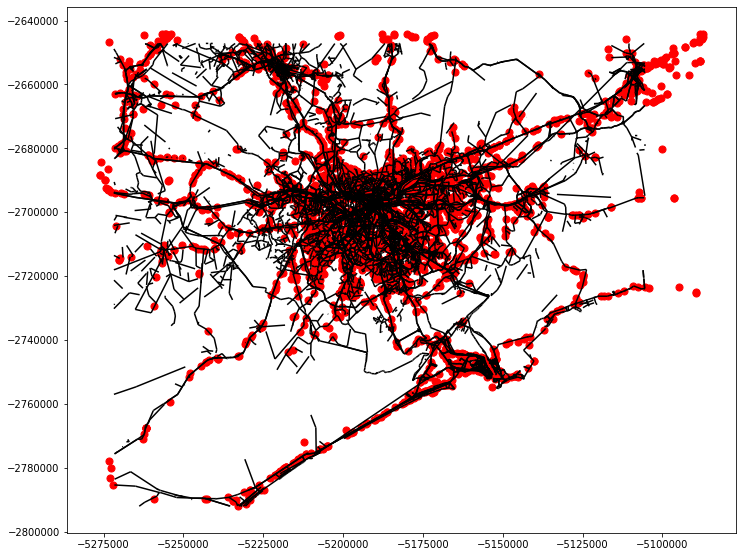

In [10]:
# Plot crashes on roads
fig, ax = plt.subplots(1, figsize=(12, 12))
base = roads.plot(color='black', ax=ax)
crashes.plot(ax=base, marker='o', color='red', markersize=50)

# Display
plt.show()

## Address our question

### What is the month with the most accidents?

In [11]:
# Assign a score to each road.
# <https://pandas.pydata.org/pandas-docs/version/0.23/generated/
#     pandas.core.groupby.DataFrameGroupBy.agg.html>
g = crashes[['DESC_MES']].copy()
g['num_accidents'] = 1
g = g.groupby('DESC_MES', as_index=False).agg({
    'num_accidents': 'sum', 
    })

# Sort
g = g.sort_values('num_accidents', ascending=False)

# Display
g.head()

,DESC_MES,num_accidents
1,AGOSTO,394
10,OUTUBRO,376
11,SETEMBRO,365
9,NOVEMBRO,352
2,DEZEMBRO,243


### What is the week day with the most accidents?

In [12]:
# Assign a score to each road.
g = crashes[['DIA_SEM']].copy()
g['num_accidents'] = 1
g = g.groupby('DIA_SEM', as_index=False).agg({
    'num_accidents': 'sum', 
    })

# Sort
g = g.sort_values('num_accidents', ascending=False)

# Display
g.head()

,DIA_SEM,num_accidents
0,DOMINGO,654
6,SÁBADO,586
2,QUINTA,402
5,SEXTA,388
1,QUARTA,373


### What is the age group with the most accidents?

In [13]:
# Assign a score to each road.
g = crashes[['FAIX_ETAR']].copy()
g['num_accidents'] = 1
g = g.groupby('FAIX_ETAR', as_index=False).agg({
    'num_accidents': 'sum', 
    })

# Sort
g = g.sort_values('num_accidents', ascending=False)

# Display
g.head()

,FAIX_ETAR,num_accidents
1,18-24,508
2,25-29,342
4,35-39,289
3,30-34,288
6,45-49,228


### What are the most dangerous drivers ranked by age and sex?

In [14]:
# Assign a score to each road.
g = crashes[['SEXO', 'FAIX_ETAR']].copy()
cond = (g['SEXO'] == 'MASCULINO')
g2 = g[ cond ].copy()
g2['num_accidents'] = 1
g2 = g2.groupby('FAIX_ETAR', as_index=False).agg({
    'num_accidents': 'sum', 
    })

# Sort
g2 = g2.sort_values('num_accidents', ascending=False)

# Display
print('MASCULINO')
g2.head()

MASCULINO


,FAIX_ETAR,num_accidents
1,18-24,433
2,25-29,300
3,30-34,238
4,35-39,230
6,45-49,199


In [15]:
# Assign a score to each road.
g = crashes[['SEXO', 'FAIX_ETAR']].copy()
cond = (g['SEXO'] == 'FEMININO')
g2 = g[ cond ].copy()
g2['num_accidents'] = 1
g2 = g2.groupby('FAIX_ETAR', as_index=False).agg({
    'num_accidents': 'sum', 
    })

# Sort
g2 = g2.sort_values('num_accidents', ascending=False)

# Display
print('FEMININO')
g2.head()

FEMININO


,FAIX_ETAR,num_accidents
1,18-24,74
0,0-17,63
4,35-39,57
3,30-34,50
10,65-69,49


### How many people are killed on our roads each year?

In [16]:
# Assign a score to each road.
g = crashes[['ANO']].copy()
g['num_accidents'] = 1
g = g.groupby('ANO', as_index=False).agg({
    'num_accidents': 'sum', 
    })

# Sort
g = g.sort_values('num_accidents', ascending=False)

# Display
g.head()

,ANO,num_accidents
1,2017,2056
0,2016,1041


### What are casualties by road user type?


In [17]:
# Assign a score to each road.
g = crashes[['VEIC']].copy()
g['num_accidents'] = 1
g = g.groupby('VEIC', as_index=False).agg({
    'num_accidents': 'sum', 
    })

# Sort
g = g.sort_values('num_accidents', ascending=False)

# Display
g.head()

,VEIC,num_accidents
7,PEDESTRE,1151
3,MOTOCICLETA,1081
0,AUTOMOVEL,536
1,BICICLETA,172
4,NAO DISPONIVEL,81


### Do more deaths occur on country roads than on motorways?

In [18]:
# Assign a score to each road.
g = crashes[['VIA']].copy()
g['num_accidents'] = 1
g = g.groupby('VIA', as_index=False).agg({
    'num_accidents': 'sum', 
    })

# Sort
g = g.sort_values('num_accidents', ascending=False)

# Display
g.head()

,VIA,num_accidents
2,Vias Municipais,2067
1,Rodovias,1024
0,Não Disponível,6


### What are crashiest roads at night?

In [19]:
# Assign a score to each road.
g = crashes[['TURNO', 'NOME']].copy()
cond = (g['TURNO'] == 'NOITE')
g2 = g[ cond ].copy()
g2['num_accidents'] = 1
g2 = g2.groupby('NOME', as_index=False).agg({
    'num_accidents': 'sum', 
    })

# Sort
g2 = g2.sort_values('num_accidents', ascending=False)

# Display
g2.head()

,NOME,num_accidents
256,BR 116,59
521,SP 055,31
525,SP 070,23
535,SP 160,22
542,SP 280,20


### What are crashiest roads for motorcycle?

In [20]:
# Assign a score to each road.
g = crashes[['VEIC', 'NOME']].copy()
cond = (g['VEIC'] == 'MOTOCICLETA')
g2 = g[ cond ].copy()
g2['num_accidents'] = 1
g2 = g2.groupby('NOME', as_index=False).agg({
    'num_accidents': 'sum', 
    })

# Sort
g2 = g2.sort_values('num_accidents', ascending=False)

# Display
g2.head()

,NOME,num_accidents
296,BR 116,33
633,SP 160,21
620,SP 055,21
640,SP 280,19
643,SP 330,17


### What are the crashiest roads? (crash per meter)

In [21]:
# For each road collect the crashes near it

# Roads
r = roads[['geometry', 'osm_id', 'name', 'class']].copy()

# Display
r.head().T

,0,1,2,3,4
geometry,LINESTRING (-5200942.68167244 -2711257.2541036...,LINESTRING (-5217357.888066844 -2664814.567058...,LINESTRING (-5213664.063075678 -2680919.689468...,LINESTRING (-5210107.268626218 -2674538.878684...,LINESTRING (-5205729.737183766 -2682580.977264...
osm_id,4273889,4300267,4300280,4312745,4312746
name,Avenida Nações Unidas,Rodovia Anhanguera,Rodovia Anhanguera,Rodovia dos Bandeirantes,Rodovia dos Bandeirantes
class,highway,highway,highway,highway,highway


In [22]:
# Shapely - "Buffer" crash points
# buffer() is used to produce approximately circular polygons
# <http://shapely.readthedocs.io/en/stable/manual.html>
buf = 200    # meters
c = crashes[['geometry', 'TIPO']].copy()
c['geometry'] = c['geometry'].buffer(buf)

# Display
c.head()

,geometry,TIPO
0,"POLYGON ((-5185501.816 -2688560.050, -5185502....",ATROPELAMENTO
9426,"POLYGON ((-5185676.031 -2687739.821, -5185676....",OUTROS
9427,"POLYGON ((-5185395.283 -2688023.299, -5185396....",ATROPELAMENTO
9428,"POLYGON ((-5185951.435 -2696029.844, -5185952....",CHOQUE
9429,"POLYGON ((-5163638.445 -2698382.098, -5163639....",CHOQUE


In [23]:
# Spatial-join roads and buffered crash points 
f3 = gpd.sjoin(r, c, how='inner', op='intersects')

# Save
path = DirOut/Temp
f3.to_csv(path, index=False)

# Display
f3.head()

,geometry,osm_id,name,class,index_right,TIPO
3,"LINESTRING (-5210107.269 -2674538.879, -520750...",4312745,Rodovia dos Bandeirantes,highway,12510,COLISAO
197,"LINESTRING (-5210099.664 -2674490.126, -521173...",4614790,Rodovia dos Bandeirantes,highway,12510,COLISAO
4734,"LINESTRING (-5207468.586 -2676905.821, -521009...",49670754,Rodovia dos Bandeirantes,highway,12510,COLISAO
30956,"LINESTRING (-5211548.861 -2673705.890, -521010...",356327565,Rodovia dos Bandeirantes,highway,12510,COLISAO
4,"LINESTRING (-5205729.737 -2682580.977, -520613...",4312746,Rodovia dos Bandeirantes,highway,10792,COLISAO


In [24]:
# Assign a crash score to each road.
# Use the number of crashes per meter.
# Alternatively, could weight crashes by severity.
# <https://pandas.pydata.org/pandas-docs/version/0.23/generated/
#     pandas.core.groupby.DataFrameGroupBy.agg.html>
f3['num_crashes'] = 1
g = f3.groupby('name', as_index=False).agg({
    'num_crashes': 'sum', 
    'osm_id'     : 'first',
    'geometry'   : 'first',
    })
# Sort
g = g.sort_values('num_crashes', ascending=False)

# Display
g.head()

,name,num_crashes,osm_id,geometry
1462,Rodovia Presidente Dutra,268,4317932,"LINESTRING (-5170990.965 -2686014.651, -517192..."
1401,Rodovia Anchieta,191,4618805,"LINESTRING (-5184947.216 -2711631.051, -518545..."
950,Avenida Santos Dumont,134,4331532,"LINESTRING (-5190956.677 -2695890.295, -519090..."
1467,Rodovia Raposo Tavares,124,4768061,"LINESTRING (-5236758.813 -2704562.986, -523609..."
1479,Rodovia dos Bandeirantes,123,4312745,"LINESTRING (-5210107.269 -2674538.879, -520750..."


In [25]:
# Lost GeoDataFrame during groupby
g = gpd.GeoDataFrame(g, crs=WM)

# Calculate crashes / length
g['length'] = g.geometry.length
g['crash_score'] = g['num_crashes']/g['length']

# Sort
g = g.sort_values('crash_score', ascending=False)

# Save to file for posterity
path = DirOut/CrashyRoads
with path.open('w') as tgt:
     tgt.write(g.to_crs(WGS84).to_json())

# Display
g.head()

,name,num_crashes,osm_id,geometry,length,crash_score
554,Avenida Israel,21,169392405,"LINESTRING (-5200923.768 -2669889.911, -520092...",6.846982,3.067045
295,Avenida Corifeu de Azevedo Marques,82,155225411,"LINESTRING (-5203959.528 -2699696.180, -520394...",27.227511,3.011660
269,Avenida Celso Garcia,32,289910559,"LINESTRING (-5185601.158 -2696884.759, -518558...",13.850846,2.310328
551,Avenida Interlagos,78,4330573,"LINESTRING (-5196351.627 -2711143.604, -519637...",43.359957,1.798895
393,Avenida Duque de Caxias,33,230634570,"LINESTRING (-5192306.781 -2697108.366, -519229...",18.644964,1.769915


In [26]:
# Pandas Dataframe.describe() method
print(g.describe())

       num_crashes        length  crash_score
count  2687.000000   2687.000000  2687.000000
mean      5.014514    663.205047     0.037622
std      11.582660   1016.565710     0.137111
min       1.000000      4.230406     0.000084
25%       1.000000    134.310068     0.002432
50%       2.000000    338.572086     0.006911
75%       4.000000    783.938382     0.024212
max     268.000000  12849.649062     3.067045


In [27]:
# Color-code roads by crash score with Spectra 
# Use Colorbrewer spectral colors
colors = reversed(['#d7191c', '#d7191c','#fdae61','#ffffbf','#abdda4','#2b83ba'])  
cuts = [0] + [g['crash_score'].quantile(k/100) for k in [25, 50, 75, 98, 100]]
scale = spectra.scale(colors).colorspace('lch').domain(cuts)
g['color'] = g['crash_score'].map(lambda x: scale(x).hexcode)

# Folium style function
def style(x):
    return {
        'color': x['properties']['color'],
        'weight': 5,
    }

# Plot on a slippy map with Folium
g = g.to_crs(WGS84) 
lon, lat = g.geometry.iat[0].coords[0]  # Center on crashiest road
tiles = 'https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png'
mappy = folium.Map(location=[lat, lon], zoom_start=16, tiles=tiles, attr='OSM')
geo = json.loads(g.sort_values('crash_score').to_json())
folium.GeoJson(geo, 
  style_function=style).add_to(mappy)

# Display
mappy

Note: github seems to not work with mappy. See below the static screenshot version.

![](img/Screenshot_01.png)

## Final note

This work continues in the discipline CAP-359 (using Portuguese language)

- https://github.com/efurlanm/359

## References

- http://pyvideo.org/kiwi-pycon-2017/introducing-geopandas.html
- http://www.racfoundation.org/motoring-faqs/safety
- http://www.nextzen.org/metro-extracts/index.html
- http://www.infosiga.sp.gov.br/Home/InfoMapaRelatorio
- http://pandas.pydata.org
- http://geopandas.org
- http://matplotlib.org
- http://numpy.org
- http://docs.python.org
- http://pypi.org/project/Shapely
- http://python-visualization.github.io/folium
- http://github.com/jsvine/spectra
- http://wiki.openstreetmap.org/wiki/Map_Features
- http://en.wikipedia.org/wiki/Web_Mercator_projection
- http://pandas.pydata.org/pandas-docs
- http://shapely.readthedocs.io/en/stable/manual.html
- http://www.machinelearningplus.com/python/parallel-processing-python
- http://docs.python.org/3/library/multiprocessing.html
- http://pypi.org/project/pathos